In [1]:
import sys
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random

import matplotlib.pyplot as plt

In [4]:
from matplotlib.patches import Ellipse, transforms
# https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def plot_ellipse(Sigma, mu, ax, n_std=3.0, facecolor='none', edgecolor='k', plot_center='true', **kwargs):
    cov = Sigma
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = (transforms.Affine2D()
                        .rotate_deg(45)
                        .scale(scale_x, scale_y)
                        .translate(mean_x, mean_y))

    ellipse.set_transform(transf + ax.transData)

    if plot_center:
        ax.plot(mean_x, mean_y, '.')
    return ax.add_patch(ellipse)


In [5]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

%config InlineBackend.figure_format = "retina"

In [6]:
def check_symmetric(a, rtol=1.1):
    return jnp.allclose(a, a.T, rtol=rtol)


def plot_data(sample_state, sample_obs, ax=None):
    ax = ax if ax is not None else plt.subplots()[1]
    ax.plot(*sample_state.T, label="state space")
    ax.scatter(*sample_obs.T, s=60, c="tab:green", marker="+")
    ax.scatter(*sample_state[0], c="black", zorder=3)
    ax.legend()
    ax.set_title("Noisy observations from hidden trajectory")
    plt.axis("equal")


def plot_inference(sample_obs, mean_hist, Sigma_hist, ax=None):
    ax = ax if ax is not None else plt.subplots()[1]
    ax.scatter(*sample_obs.T, marker="+", color="tab:green")
    ax.plot(*mean_hist.T, c="tab:orange", label="filtered")
    ax.scatter(*mean_hist[0], c="black", zorder=3)
    plt.legend()
    collection = [(mut, Vt) for mut, Vt in zip(mean_hist[::4], Sigma_hist[::4])
                  if Vt[0, 0] > 0 and Vt[1, 1] > 0 and abs(Vt[1, 0] - Vt[0, 1]) < 7e-4]
    for mut, Vt in collection:
        plot_ellipse(Vt, mut, ax, plot_center=False, alpha=0.9, zorder=3)
    plt.axis("equal")

In [36]:
from jsl.nlds.base import NLDS
from jsl.nlds.extended_kalman_filter import ExtendedKalmanFilter
from jsl.nlds.unscented_kalman_filter import UnscentedKalmanFilter

In [37]:
import jsl.nlds as ds

In [43]:
def fz(x, dt): return x + dt * jnp.array([jnp.sin(x[1]), jnp.cos(x[0])])
def fx(x, *args): return x

dt = 0.4
nsteps = 100
# Initial state vector
x0 = jnp.array([1.5, 0.0])
state_size, *_ = x0.shape
# State noise
Qt = jnp.eye(state_size) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.05
alpha, beta, kappa = 1, 0, 2

key = random.PRNGKey(31415)
model = NLDS(lambda x: fz(x, dt), fx, Qt, Rt)
sample_state, sample_obs = model.sample(key, x0, nsteps)

In [70]:
ekf = ExtendedKalmanFilter.from_base(model)
_, ekf_hist = ekf.filter(x0, sample_obs, carry_params=["mean", "cov"])

ukf = UnscentedKalmanFilter.from_base(model, alpha, beta, kappa, state_size)
ukf_mean_hist, ukf_Sigma_hist = ukf.filter(x0, sample_obs)

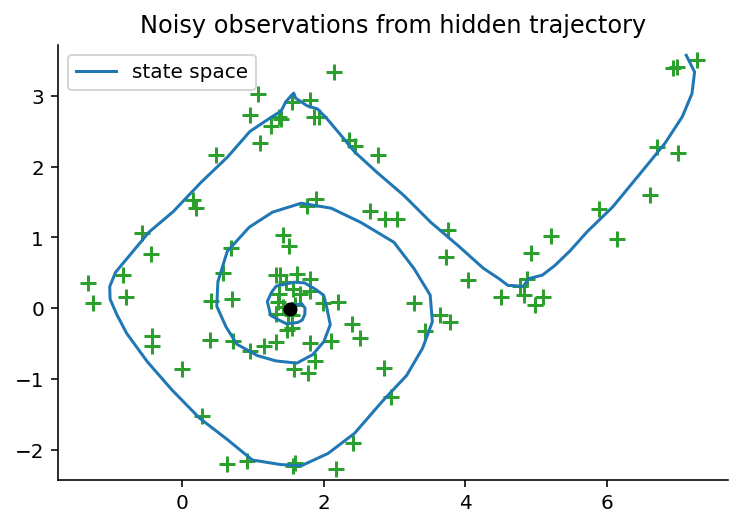

In [74]:
plot_data(sample_state, sample_obs)

Text(0.5, 1.0, 'UKF')

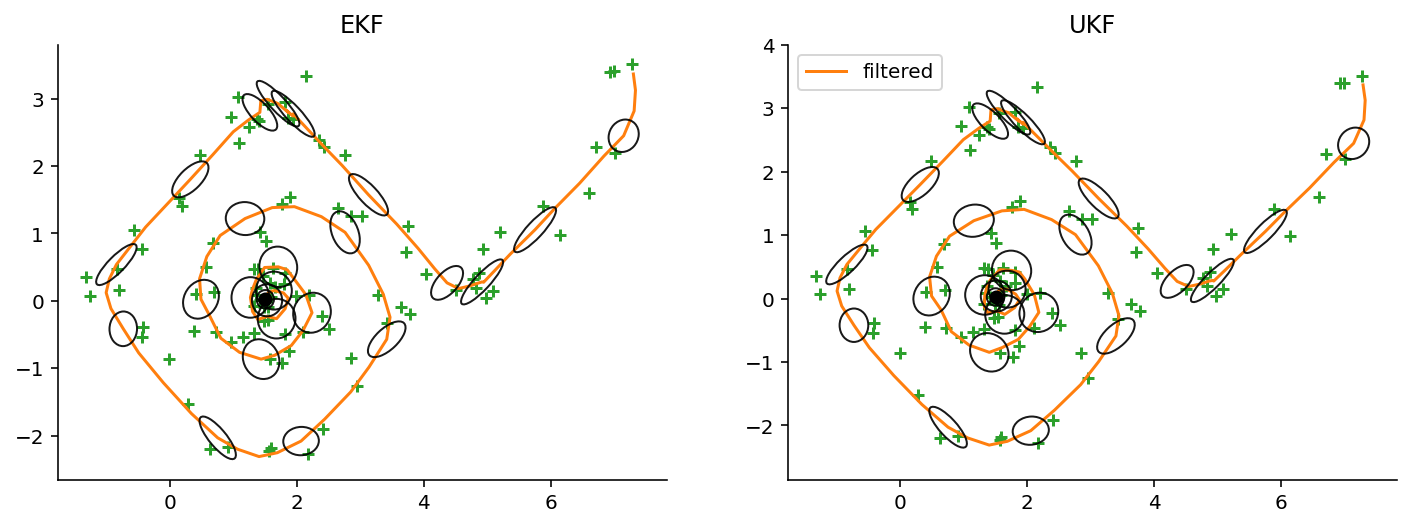

In [73]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

plot_inference(sample_obs, ekf_hist["mean"], ekf_hist["cov"], ax=ax[0])
ax[0].set_title("EKF")
plot_inference(sample_obs, ukf_mean_hist, ukf_Sigma_hist, ax=ax[1])
ax[1].set_title("UKF")